# Heart Disease Prediction Report

## Introduction

Mensah et al. (2023) state that it is estimated that around 110 million men and 70 million women have coronary (ischemic) heart disease globally, and it kills around seven million to nine million people each year from 2009 to 2019. Coronary heart disease, also known as ischemic heart disease, is a heart problem caused by a lack of blood supply to the heart muscle impacted by the narrowed heart (coronary) arteries. This global issue has raised our awareness to be more concerned with it and if possible contribute to it.

To follow up on the coronary heart disease issue, we initiate a data analysis project that is strongly related to the problem, especially in the initial action of the disease, which is the early detection of the heart disease. We will utilize the heart disease dataset from the UC Irvine Machine Learning Repository, focusing on the Cleveland database, as it is the most complete and commonly used by ML researchers. The data set used provides thirteen different predictive variables, but we will be more focused on five variables that show the most strong correlation with the result (heart disease detection). After doing some exploration, we will classify whether the patient has heart disease or not based on the available predictive variables.

## Methods & Results

### Read Data
First, we load the tidyverse library and read heart disease data from the csv file and tidymodels for creating a KNN model. Since the data doesn't have column names, we added the column names based on the dataset documentation. 

In [1]:
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://raw.githubusercontent.com/wtarit/dsci-100-project/main/heart_disease_dataset/processed.cleveland.data"
heart_disease <- read_csv(url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", 
                                             "slope", "ca", "thal", "num"))
heart_disease

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Table 1: Heart Disease Dataset

We can see that the data is already in tidy format, but some of the columns don't have the correct data type, e.g (chr instead of int), so we convert it to the correct datatype. We also drop rows that contain N.A values.

In [3]:
heart_disease <- heart_disease |> 
    mutate(ca = as.integer(ca), thal = as.integer(thal)) |>
    drop_na()

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.integer(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


We can check the distribution of data by counting a number of rows using the num column.

In [4]:
class_distribution <- heart_disease |>
    group_by(num) |> 
    summarize(count = n())
class_distribution

num,count
<dbl>,<int>
0,160
1,54
2,35
3,35
4,13


Table 2: Heart Disease Classification Class Distribution

In this table, based on the dataset documentation num represents heart disease, where 0 indicates no presence of heart disease in the patient and 1 - 4 varying degrees of the disease. The data is quite unbalanced as we see a prevelance in patients without the presence of heart disease. Since there is a small number of data to separate different type of heart disease, in this analysis, we will only focus on classifying whether the patient have the heart disease or not.  

We will combine num 1, 2, 3, and 4 into one class and since this is a classification problem where we predict the presence of heart disease in a patient, we will make the Class a factor type.

In [5]:
heart_disease_binary <- heart_disease |>
    mutate(Class = as_factor(num != 0)) |>
    select(-num)

heart_disease_binary

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,FALSE
67,1,4,160,286,0,2,108,1,1.5,2,3,3,TRUE
67,1,4,120,229,0,2,129,1,2.6,2,2,7,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7,TRUE
57,1,4,130,131,0,0,115,1,1.2,2,1,7,TRUE
57,0,2,130,236,0,2,174,0,0.0,2,1,3,TRUE


Table 3: Heart Disease Dataset after converting class to Binary

We recheck the distribution of the Class to check that it distribute more evenly.

In [6]:
binary_class_distribution <- heart_disease_binary |>
    group_by(Class) |> 
    summarize(count = n())
binary_class_distribution

Class,count
<fct>,<int>
FALSE,160
TRUE,137


Table 4: Heart Disease Classification Binary Class Distribution

We can see that the class split more evenly between FALSE (Not have heart disease) and TRUE (Have heart disease).   

We will now split 80% of our data for training and keep 20% for testing. 

In [7]:
set.seed(1234)
heart_disease_split <- initial_split(heart_disease_binary, prop = 0.8, strata = Class)  
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

### Data Visualization

We will now undergo data visualization to determine if there are any correlation of the presence of heart disease with any other features.

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.
Warning message in Ops.factor(Class):
“‘-’ not meaningful for factors”


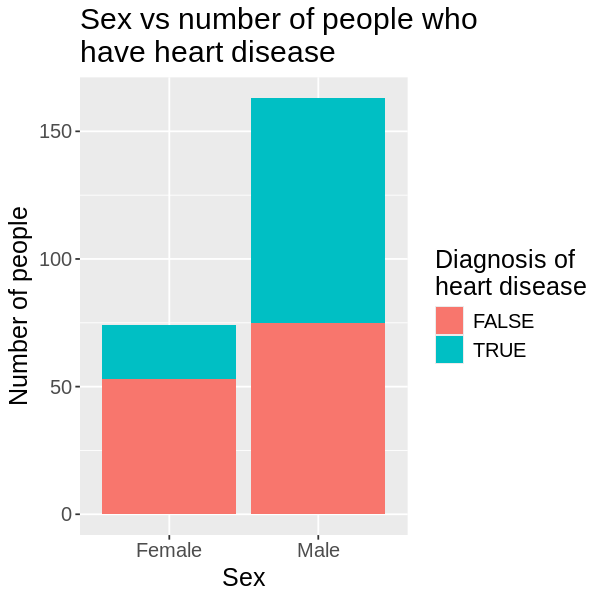

In [8]:
options(repr.plot.width = 5, repr.plot.height = 5)

heart_disease_count_sex <- heart_disease_train |>
    group_by(sex, Class) |>
    summarize(count = n()) |>
    mutate(sex = ifelse(sex == 0, "Female", "Male"))

heart_disease_count_sex_plot <- ggplot(heart_disease_count_sex, aes(x = sex, y=count, fill = Class, group = -Class)) +
    geom_bar(stat = "identity", position = "stack") +
    labs(x = "Sex", y = "Number of people", fill = "Diagnosis of \nheart disease") +
    ggtitle("Sex vs number of people who \nhave heart disease") +
    theme(text = element_text(size = 15))

heart_disease_count_sex_plot

Figure 1: Bar plot showing number of people that have heart disease in Male and Female. 

We can see that in the dataset, we have twice the number of data recorded for males compared to females. We also notice that there's a higher chance that we diagnosed heart disease in males. Which suggest that sex have a factor for presence of heart disease in patients.

`summarise()` has grouped output by 'thal'. You can override using the
`.groups` argument.
Warning message in Ops.factor(Class):
“‘-’ not meaningful for factors”


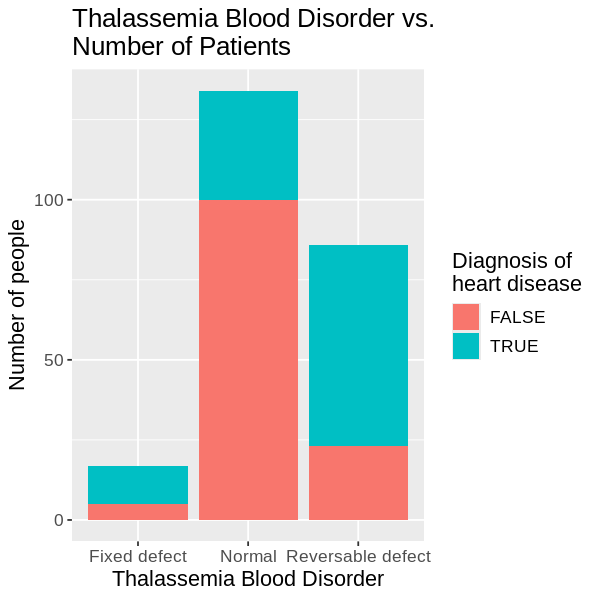

In [9]:
options(repr.plot.width = 5, repr.plot.height = 5)

heart_disease_count_thal <- heart_disease_train |>
    drop_na() |>
    group_by(thal, Class) |>
    summarize(count = n()) |>
    mutate(thal_str = case_when(thal == 3.0 ~ "Normal", 
                                                 thal == 6.0 ~ "Fixed defect",
                                                 thal == 7.0 ~ "Reversable defect"))

heart_disease_count_thal_plot <- ggplot(heart_disease_count_thal, aes(x = thal_str, y=count, fill = Class, group = -Class)) +
    geom_bar(stat = "identity", position = "stack") +
    labs(x = "Thalassemia Blood Disorder", y = "Number of people", fill = "Diagnosis of \nheart disease") +
    ggtitle("Thalassemia Blood Disorder vs. \nNumber of Patients") + #prev was vs. people who have heart disease
    theme(text = element_text(size = 13))

heart_disease_count_thal_plot

Figure 2: Bar plot showing number of people that have heart disease classified by type of Thalassemia Blood Disorder. 

This plot shows that people with Thalassemia blood disorder, blood disorder caused when the body doesn't make enough of a protein called hemoglobin, are likely to get heart disease compared to patients that do not have the disorder.

Source : https://www.cdc.gov/ncbddd/thalassemia/index.html#:~:text=Thalassemia%20is%20an%20inherited%20

`summarise()` has grouped output by 'restecg'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Class'. You can override using the
`.groups` argument.


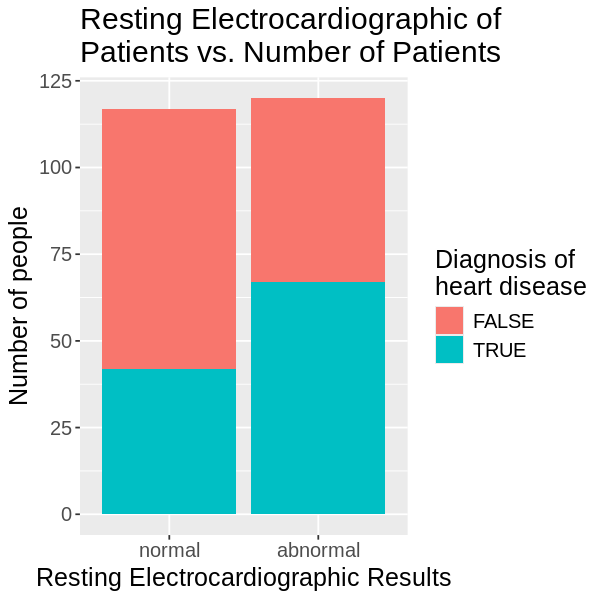

In [10]:
options(repr.plot.width = 5, repr.plot.height = 5)

heart_disease_count_restecg <- heart_disease_train |>
    drop_na() |>
    group_by(restecg, Class) |>
    summarize(count = n()) |>
    mutate(restecg = as_factor(ifelse(restecg == 0, "normal", "abnormal"))) %>%
    group_by(Class, restecg) %>%
    summarize(count = sum(count)) %>%
    ungroup()

heart_disease_count_restecg_plot <- ggplot(heart_disease_count_restecg, aes(x = restecg, y=count, fill = Class)) +
    geom_bar(stat = "identity", position = "stack") +
    labs(x = "Resting Electrocardiographic Results", y = "Number of people", fill = "Diagnosis of \nheart disease") +
    ggtitle("Resting Electrocardiographic of \nPatients vs. Number of Patients") +
    theme(text = element_text(size = 15))

heart_disease_count_restecg_plot

Figure 3: Bar plot showing number of people that have heart disease in people with normal and abnormal Resting Electrocardiographic. 

Here what we categorized as 'abnormal' are the integer values of 1 and 2 in restecg. Where based on the dataset documentation, integer values of 1 in restecg have ST-T wave abnormality (slight abnormality) and the integer values of 2  shosg probable or definite left ventricular hypertrophy by Estes' criteri (abnormality). While having a value of 0 in restecg means there are no abnormality detected in the patient's Resting Electrocardiographic results.

The plot above shows that people having abonormal resting  electrocardiograhic results are more likely to have a diagnosis of heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


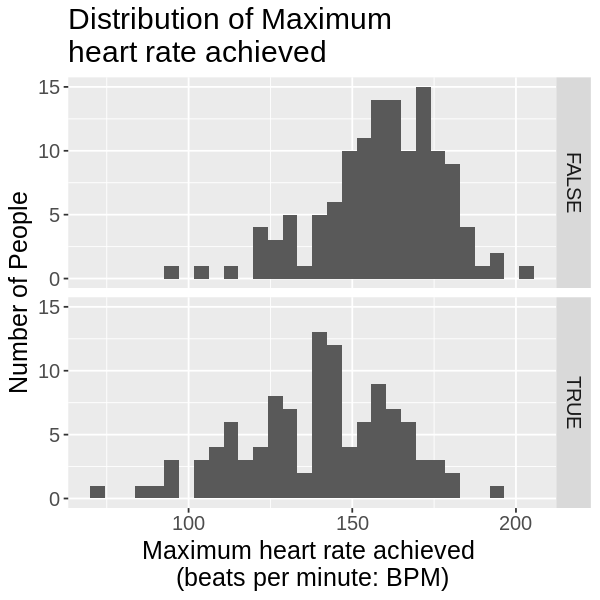

In [11]:
thalach_dist <- ggplot(heart_disease_train, aes(x = thalach)) +
    geom_histogram() +
    facet_grid(rows = vars(Class)) +
    ggtitle("Distribution of Maximum \nheart rate achieved") +
    xlab("Maximum heart rate achieved \n(beats per minute: BPM)") +
    ylab("Number of People") +
    theme(text = element_text(size = 15))

thalach_dist

Figure 4: Histogram showing distribution of maximum heart rate in people with and without heart disease.

From the histogram, we can see that people without heart disease will likely have higher maximum heart rate achieved. Therefore, people who achieve lower maximum heart rate are more likely to have heart disease.

`summarise()` has grouped output by 'cp'. You can override using the `.groups`
argument.


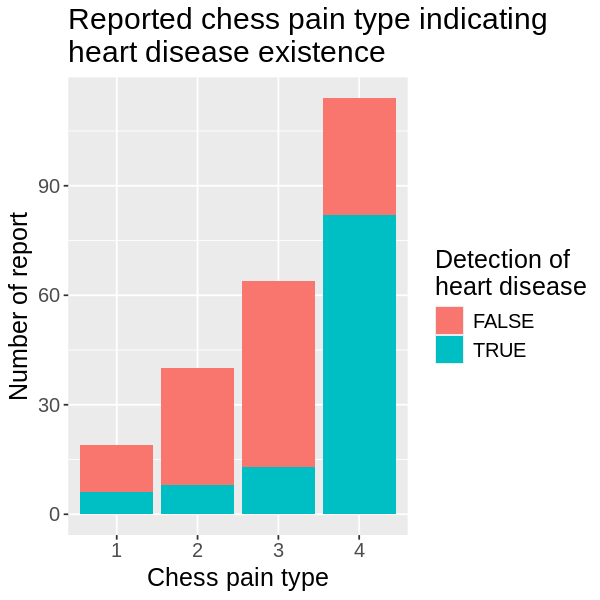

In [12]:
options(repr.plot.width = 5, repr.plot.height = 5)

heart_disease_count_cp <- heart_disease_train |>
    group_by(cp, Class) |>
    summarize(count = n()) |>
    mutate(cp = as_factor(cp))

heart_disease_count_cp_plot <- heart_disease_count_cp |>
    ggplot(aes(x = cp, y = count, fill = Class)) +
        geom_bar(stat = "identity") +
        labs(fill = "Detection of \nheart disease") +
        xlab("Chess pain type") +
        ylab("Number of report") +
        ggtitle("Reported chess pain type indicating \nheart disease existence") +
        theme(text = element_text(size = 15))

heart_disease_count_cp_plot

Figure 5: Bar plot showing number of people that have heart disease in people with different chess pain type where 1 is typical angina, 2 is atypical angina, 3 is non-anginal pain, and 4 is asymptomatic. 

The plot above indicates the relationship between chess pain type and the existence of heart disease. It can be inferred that people experiencing the most severe chest pain type, type 4 (asymptomatic), show a high percentage of suffering from heart disease.

## Create a knn model

From doing exploratory data analysis, we find that variable that have high impact to heart disease are Sex, Thalassemia Blood Disorder (thal), Resting Electrocardiographic Results (restecg), Maximum heart rate achieved (thalach), and Chess pain type (cp).

We will use these five predictors to build a k-nearest neighbors (KNN) model for classification. To train a model, we will center the variables and scale them to ensure each predictor has a similar effect on the result. We will use cross-validation to select the optimal k value by focusing on accuracy and recall. We want the model to predict heart disease correctly, but we also need to make sure that people who have heart disease are classified as having heart disease.

First, we select only the predictors that we are interested in and the Class from training and testing dataset.

In [13]:
heart_disease_train <- heart_disease_train |>
    select(thal, sex, cp, thalach, restecg, Class)

heart_disease_test <- heart_disease_test |>
    select(thal, sex, cp, thalach, restecg, Class)

We split our training dataset into 5 folds to perform cross validation and find optimal k.

In [14]:
heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = Class)

We create a recipe which specify the Class column as a label and the rest as a predictors. We specified preprocessing step which center our variable and scale it to the same range to ensure each predictor has a similar effect on the result.

In [15]:
heart_disease_recipe <- recipe(Class ~ ., data=heart_disease_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 
heart_disease_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 5



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



To find best k value we create a KNN model specification with and set `neighbors = tune()`.

In [16]:
heart_disease_tune <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_disease_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We create a tibble containing all k value that we want to try training our model with. In this case we select to try finding accuracy using `k = 2` to `k = 20`.

In [17]:
k_vals <- tibble(neighbors = seq(from = 2, to = 20, by = 1))

To fit the model to different k value, we create a workflow and add our recipe, model to it. We use `tune_grid` function to fit the model to different k value and then `collect_metrics()` to gather the result.

In [18]:
heart_disease_tune_fit <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(heart_disease_tune) |>
    tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- heart_disease_tune_fit |>
  filter(.metric == "accuracy")

To visualize how our model perform using different k value, we plot a line chart showing Accuracy vs number of neighbours (k value).

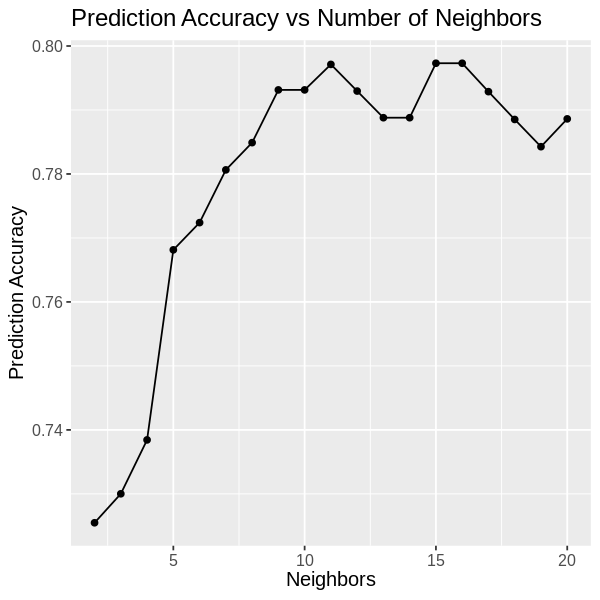

In [19]:
options(repr.plot.width = 5, repr.plot.height = 5)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Prediction Accuracy") +
    ggtitle("Prediction Accuracy vs Number of Neighbors") +
    theme(text = element_text(size = 12))

accuracy_vs_k

Figure 6: Line plot showing Prediction Accuracy vs Number of Neighbors

From the line plot, we can see that k value that give high accuracy are 11, 15, and 16.  

To get the exact value of k that give best prediction accuracy, we can sort the result table by accuracy and pick the k from row with highest accuracy.

In [20]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 15

Hence, we will use the K = 15 to obtain the most accurate prediction.

### Build actual model using the best K

Here, we will build the actual model using K = 15 by using KNN algorithm. 

In [21]:
heart_disease_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = 15) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_disease_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 15
  weight_func = rectangular

Computational engine: kknn 


Now, we will fit our recipe, which is the old one can be reused, and our new model that has already been set with K = 15 neighbors.

In [22]:
heart_disease_fit <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(heart_disease_spec) |>
    fit(data = heart_disease_train) 

The heart disease test data set will be tested to be predicted using the preprocessed training data and model in the workflow above.

In [23]:
heart_disease_predictions <- predict(heart_disease_fit, heart_disease_test) |>
    bind_cols(heart_disease_test)

heart_disease_predictions |>
  metrics(truth = Class, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9


It turns out that our prediction accuracy, the comparison between the number of correct predictions and total number of predictions, is approximately 90% which is relatively a pretty good and reliable result because of high accuracy.

Here, we will also specify the precision and recall of our prediction that was done above. Precision quantifies how many of the positive predictions made are actually positive. Recall quantifies how many of the actual positive test set observations were identified as positive by the prediction. Significantly, calculating accuracy only is not enough since it would be very dangerous to produce a false result (no existence of heart disease) to the person that actually has heart disease (should output true). In this case, it is strongly related to high recall value. Besides, making predictions with high precision will prevent making false positive results.

In [24]:
heart_disease_predictions |>
    precision(truth = Class, estimate = .pred_class, event_level="first")
heart_disease_predictions |>
    recall(truth = Class, estimate = .pred_class, event_level="first")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8823529


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9375


It turns out that the prediction above has a precision of 88.2% and a recall of 93.8% which are as good as our accuracy value. This calculation means that not only our data analysis is good enough to predict true negative, but it is also a good analysis to predict true positive (predict that the heart disease exists and it actually exists).

Now, we will evaluate model using confusion matrix to visualize it in a better way.

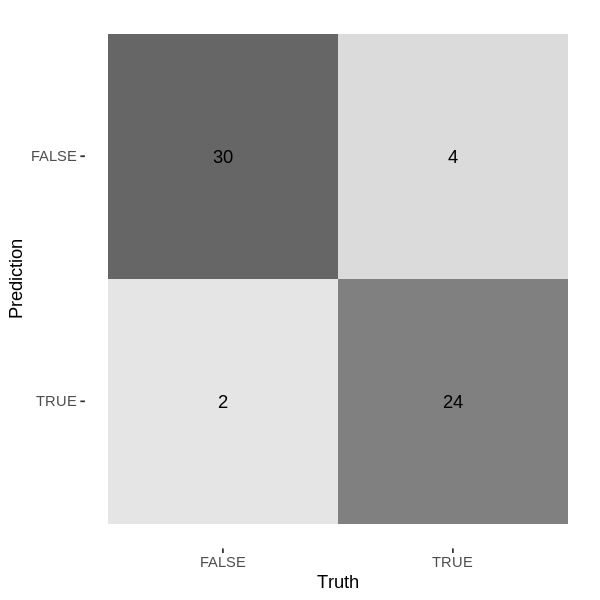

In [25]:
confusion <- heart_disease_predictions |>
             conf_mat(truth = Class, estimate = .pred_class)
autoplot(confusion, type = "heatmap")

From the confusion matrix above, it can be seen that the data analysis produced results with 24 true positive, 2 false positive, 30 true negative, and 4 false negative results. It can be concluded that our prediction produce a good and relatively reliable results.

### NOTE
All predictors, k = 15, accuracy = 55.7  
All predictors, k = 8, accuracy = 59.0  
**No age, k = 14, accuracy = 62.2**  
No age, No restecg, k = 12, accuracy = 60.6  
No age, No thalach, k = 6, accuracy = 60.6  
sex, thal, k = 11, accuracy = 52.4  
sex, thal, cp, k = 11, accuracy = 59.0  
sex, thal, cp, restecg, k = 12, accuracy = 57.3  
sex, thal, cp, trestbps, k = 7, accuracy = 55.7  

Binary no age 93.3  
Binary sex, thal, cp 91.6

After we have the trained model, we will evaluate it with the test dataset, measuring its accuracy, precision, and recall. We will also create a confusion matrix to evaluate the prediction result for each class. 

## Discussion

##### summarize what you found (delete later)

The data analysis performed in this report has produced a tool that will be useful in terms of early detection of heart disease with a high percentage of accuracy, which is approximately 90%. The analysis was done with KNN classification to predict the existence of heart disease relying on 5 carefully selected predictors. This finding and accuracy are relatively reliable in performing a quick examination and detection of the existence of heart disease that does not involve complicated medical examination.

The model's effectiveness can significantly decrease the time and resources usually needed for heart disease diagnosis, enabling quicker and potentially earlier therapeutic actions.This is especially valuable in medical environments that are characterised by a high level of activity or limited resources.

Also, the model's success creates opportunities for further study. One immediate interest is exploring strategies to minimize heart disease risk factors. Understanding these factors could lead to preventative measures that reduce the disease's occurrence. Future studies might also incorporate broader datasets to enhance the model's accuracy and utility across different populations.

Our findings not only achieve our initial objectives but also establish a foundation for enhancing techniques to prevent and identify cardiac conditions at an early stage.This could lead to more personalized and cost-effective healthcare approaches.


## References

##### Data Source

Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart disease. *UCI Machine Learning Repository*. https://doi.org/10.24432/C52P4X.

##### Other Source

Mensah, G. A., Fuster, V., Murray, C. J. L., Roth, G. A. (2023). Global burden of cardiovascular diseases and risks, 1990-2022. *Global Burden of Diseases*. https://doi.org/10.1016/j.jacc.2023.11.007.

Institute of Medicine (US) Committee on Social Security Cardiovascular Disability Criteria. (2010). Cardiovascular disability: Updating the social security listings. *Washington (DC): National Academies Press (US)*. Available from: https://www.ncbi.nlm.nih.gov/books/NBK209964/